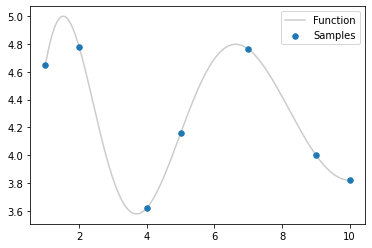

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Our funky function here
def fn(xs):
    return np.exp((xs + 10.5)**0.1) + np.sin(xs) / (xs + 1) + np.cos(2.5 * xs**0.5)**2

# Lets generate both the good visualisation of the function and some samples
xs = np.array([1, 2, 4, 5, 7, 9, 10])
x_fine = np.linspace(1, 10, 200)
ys, y_fine = fn(xs), fn(x_fine)

# And plot it out
plt.plot(x_fine, y_fine, c="#ccc", label="Function")
plt.scatter(xs, ys, s=30, label="Samples", zorder=20)
plt.legend();

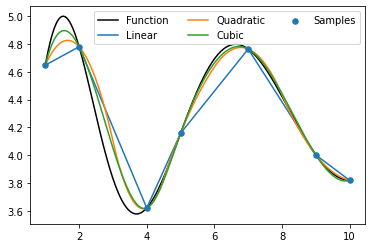

In [4]:
from scipy.interpolate import interp1d

y_linear = interp1d(xs, ys, kind="linear")(x_fine)
y_quad = interp1d(xs, ys, kind="quadratic")(x_fine)
y_cubic = interp1d(xs, ys, kind="cubic")(x_fine)

plt.scatter(xs, ys, s=30, zorder=20, label="Samples")
plt.plot(x_fine, y_fine, label="Function", color="k")
plt.plot(x_fine, y_linear, label="Linear")
plt.plot(x_fine, y_quad, label="Quadratic")
plt.plot(x_fine, y_cubic, label="Cubic")
plt.legend(ncol=3);

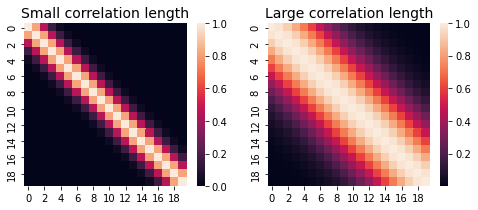

In [5]:
import seaborn as sb

def get_cov(size=20, length=50):    
    x = np.arange(size)
    cov = np.exp(-(1 / length) * (x - np.atleast_2d(x).T)**2)
    return cov

cov = get_cov()
cov2 = get_cov(length=5)

fig, axes = plt.subplots(ncols=2, figsize=(8, 3))
axes[0].set_title("Small correlation length", fontsize=14)
axes[1].set_title("Large correlation length", fontsize=14)
sb.heatmap(cov2, ax=axes[0], square=True)
sb.heatmap(cov, ax=axes[1], square=True);

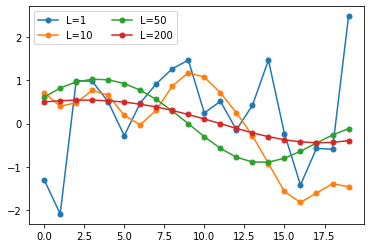

In [6]:
from scipy.stats import multivariate_normal as mn
x = np.arange(20)
for l in [1, 10, 50, 200]:
    cov = get_cov(length=l)
    rvs = mn.rvs(cov=cov)
    plt.plot(x, rvs, 'o-', ms=5, label=f"L={l}")
plt.legend(ncol=2);

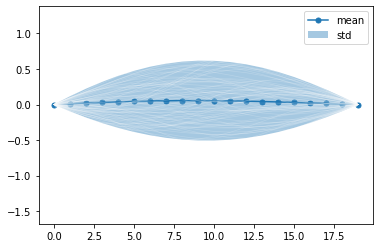

In [7]:
# In the previous code, we made one set of points four times in a loop
# Here, we generate 500 sets of our data points in one go
rvs = mn.rvs(cov=cov, size=500)

# Set the start and end points the same for all realisations
rvs -= np.linspace(rvs[:, 0], rvs[:, -1], x.size).T

# Get the mean and std of our 500 realisations
mean = rvs.mean(axis=0)
std = np.std(rvs, axis=0)

# Plot the mean and std
plt.plot(x, mean, "o-", ms=5, label="mean")
plt.fill_between(x, mean + std, mean - std, alpha=0.4, label="std")

# And for fun, lets plot 100 of the data realisations
for i in range(100):
    plt.plot(x, rvs[i, :], ls="-", c="w", alpha=0.2, lw=0.7)
plt.legend();

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:437: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1.01. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 2.0. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 20.0. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


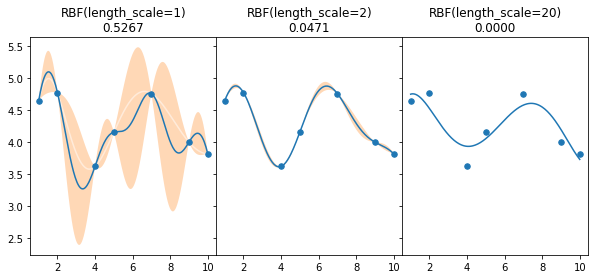

In [8]:
from sklearn.gaussian_process import GaussianProcessRegressor
import sklearn.gaussian_process.kernels as k
# Note I am NOT training these models. You can see in the bounds
# I am forcing them to have specific lengths. Normally, they would 
# fit to your data
kernels = [
    k.RBF(length_scale=1.0, length_scale_bounds=(1.0, 1.01)), 
    k.RBF(length_scale=2.0, length_scale_bounds=(2.0, 2.01)),
    k.RBF(length_scale=20.0, length_scale_bounds=(20.0, 20.01)),
]

# Make some axes please
fig, axes = plt.subplots(figsize=(10, 4), ncols=len(kernels), sharey=True)
fig.subplots_adjust(wspace=0, hspace=0)

for kernel, ax in zip(kernels, axes):
    # Fit the GP, which doesnt do much as we fixed the length_scale
    gp = GaussianProcessRegressor(kernel=kernel)
    gp.fit(np.atleast_2d(xs).T, ys)
    
    # The 2D and [:, None] stuff is because the object expects 2D data in, not 1D
    y_mean, y_std = gp.predict(x_fine[:, None], return_std=True)

    ax.scatter(xs, ys, s=30, label="Samples", zorder=20)
    ax.plot(x_fine, y_fine, label="Function", color="w", alpha=0.5)
    ax.plot(x_fine, y_mean)
    ax.fill_between(x_fine, y_mean + 2 * y_std, y_mean - 2 * y_std, alpha=0.3)
    ax.set_title(f"{kernel}\n{y_std.max():0.4f}")

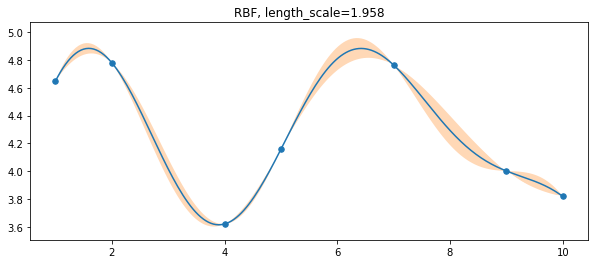

In [9]:
# Start at 2.0, fit a value between 1 and 10
kernel = k.RBF(length_scale=2.0, length_scale_bounds=(1.0, 10.0))
gp = GaussianProcessRegressor(kernel=kernel)
gp.fit(np.atleast_2d(xs).T, ys)
y_mean, y_std = gp.predict(x_fine[:, None], return_std=True)

# Plot it all, yay
fig, ax = plt.subplots(figsize=(10, 4))
ax.scatter(xs, ys, s=30, label="Samples", zorder=20)
ax.plot(x_fine, y_fine, label="Function", color="w")
ax.plot(x_fine, y_mean)
ax.fill_between(x_fine, y_mean + 2 * y_std, y_mean - 2 * y_std, alpha=0.3)
ax.set_title(f"RBF, length_scale={gp.kernel_.length_scale:0.3f}");
# Note that the fitted kernel is inside the GP, the original kernel won't be modified.

# REAL TEST!!!!!

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:437: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1.01. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:437: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 2.01. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 20.0. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


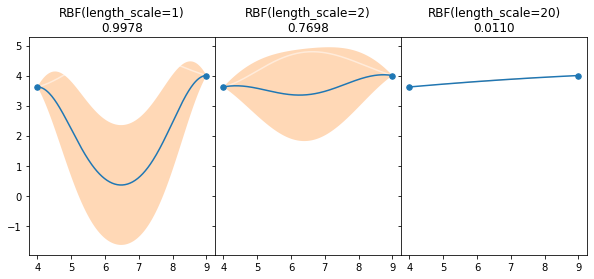

In [14]:
from sklearn.gaussian_process import GaussianProcessRegressor
import sklearn.gaussian_process.kernels as k
import numpy as np
# Note I am NOT training these models. You can see in the bounds
# I am forcing them to have specific lengths. Normally, they would 
# fit to your data
kernels = [
    k.RBF(length_scale=1.0, length_scale_bounds=(1.0, 1.01)), 
    k.RBF(length_scale=2.0, length_scale_bounds=(2.0, 2.01)),
    k.RBF(length_scale=20.0, length_scale_bounds=(20.0, 20.01)),
]

xs = np.array([ 4, 9])
x_fine = np.linspace(4, 9, 200)
ys, y_fine = fn(xs), fn(x_fine)

# Make some axes please
fig, axes = plt.subplots(figsize=(10, 4), ncols=len(kernels), sharey=True)
fig.subplots_adjust(wspace=0, hspace=0)

for kernel, ax in zip(kernels, axes):
    # Fit the GP, which doesnt do much as we fixed the length_scale
    gp = GaussianProcessRegressor(kernel=kernel)
    gp.fit(np.atleast_2d(xs).T, ys)
    
    # The 2D and [:, None] stuff is because the object expects 2D data in, not 1D
    y_mean, y_std = gp.predict(x_fine[:, None], return_std=True)

    ax.scatter(xs, ys, s=30, label="Samples", zorder=20)
    ax.plot(x_fine, y_fine, label="Function", color="w", alpha=0.5)
    ax.plot(x_fine, y_mean)
    ax.fill_between(x_fine, y_mean + 2 * y_std, y_mean - 2 * y_std, alpha=0.3)
    ax.set_title(f"{kernel}\n{y_std.max():0.4f}")